In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)

In [13]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [14]:
Normal = tf.contrib.distributions.Normal
Bernoulli = tf.contrib.distributions.Bernoulli

In [15]:
class DenseLayer:
    def __init__(self, input_size, output_size, activation=tf.nn.relu):
        self.W = new_weights([input_size, output_size])
        self.b = new_biases(output_size)
        self.f = activation
        
#     def softmax(self, x):
#         m = tf.reduce_max(x, 1)
#         x -= m
#         e = tf.exp(x)
#         return e / tf.reduce_sum(e, -1)
    
    def forward(self, X):
        return self.f(tf.matmul(X, self.W) + self.b)

In [323]:
class ConvLayer:
    def __init__(self, filter_size, num_input_channels, num_filters, stride=2, padding='VALID'):
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        self.shape = shape
        self.W = new_weights(shape)
        self.b = new_biases(num_filters)
        self.stride = stride
        self.padding = padding
    def forward(self, X):
        X = tf.nn.conv2d(X, self.W, strides=[1, self.stride, self.stride, 1], padding=self.padding)
        return X + self.b

In [324]:
class DeConvLayer:
    def __init__(self, filter_size, num_input_channels, num_filters, output_shape, stride=2, padding='VALID'):
        shape = [filter_size, filter_size, num_filters, num_input_channels]
        self.shape = shape
        self.W = new_weights(shape)
        self.b = new_biases(num_filters)
        self.stride = stride
        self.padding = padding
        self.output_shape = output_shape
    def forward(self, X):
        X = tf.nn.conv2d_transpose(X, self.W, self.output_shape, strides=[1, self.stride, self.stride, 1], padding=self.padding)
        return X + self.b

In [434]:
class BatchNormLayer:
    def __init__(self, D):
        self.mean = tf.Variable(np.zeros(D, dtype=np.float32), trainable=False)
        self.var = tf.Variable(np.ones(D, dtype=np.float32), trainable=False)
        self.gamma = tf.Variable(np.ones(D, dtype=np.float32))
        self.beta = tf.Variable(np.zeros(D, dtype=np.float32))
    
    def forward(self, X):
        return tf.nn.batch_normalization(X, self.mean, self.var, self.beta, self.gamma, 1e-3)

In [325]:
class MaxPoolLayer:
    def __init__(self, dim):
        self.dim = dim
    
    def forward(self, X):
        return tf.nn.max_pool(X, ksize=[1, self.dim, self.dim, 1], strides=[1, 2, 2, 1], padding='VALID')

In [442]:
class UpSampling:
    def __init__(self, dim):
        self.dim = dim
    
    def forward(self, X):
        _, w, h, _ = X.shape.as_list()
        return tf.image.resize_bilinear(X, size=[w*self.dim, h*self.dim])

In [327]:
class ReLUlayer:
    def forward(self, X):
        return tf.nn.relu(X)

In [457]:
class VariationalAutoencoder:
    def __init__(self, input_shape, hidden_layer_sizes, sess):
        w, h, c = input_shape
        original_input_size = w*h*c
        self.X = tf.placeholder(tf.float32, shape=(None, w, h, c))
        self.conv_encoder_layers = [ConvLayer(filter_size=3, num_input_channels=1, num_filters=32, stride=1, padding='SAME'),
                               ReLUlayer(),
                                MaxPoolLayer(dim = 2),
                                BatchNormLayer(32),
                              ConvLayer(filter_size=3, num_input_channels=32, num_filters=32, stride=1, padding='SAME'),
                               ReLUlayer(),
                               MaxPoolLayer(dim = 2),
                                   BatchNormLayer(32),]
        X = self.X
        self.conv_outputs = []
        print(X.shape)
        for layer in self.conv_encoder_layers:
            if str(layer.__class__) == "<class '__main__.ConvLayer'>":
                self.conv_outputs.append(X)
            X = layer.forward(X) 
            print(X.shape)
        
        shape = X.shape
        X = tf.reshape(X, [-1, np.prod(shape[1:])])
        print(X.shape)
        input_size = np.prod(shape[1:].as_list())
        self.encoder_layers = []
        for output_size in hidden_layer_sizes[:-1]:
            layer = DenseLayer(input_size, output_size)
            self.encoder_layers.append(layer)
            input_size = output_size
        final_output_size = hidden_layer_sizes[-1]
        final_encoder_layer = DenseLayer(input_size, 2*final_output_size, lambda x:x)
        self.encoder_layers.append(final_encoder_layer)

        for layer in self.encoder_layers:
            X = layer.forward(X)
            print(X.shape)
        
        self.means = X[:, :final_output_size]
        self.stddev = tf.nn.softplus(X[:,final_output_size:]) + 1e-6
        
        standard_normal = Normal(loc=np.zeros(final_output_size, dtype=np.float32), scale=np.ones(final_output_size, dtype=np.float32))
        sample = standard_normal.sample(tf.shape(self.means)[0])
        self.Z = sample * self.stddev + self.means
        
        self.decoder_layers = []
        input_size = final_output_size
        for output_size in reversed(hidden_layer_sizes[:-1]):
            layer = DenseLayer(input_size, output_size)
            self.decoder_layers.append(layer)
            input_size = output_size
            
        final_decoder_layer = DenseLayer(input_size, np.prod(shape[1:].as_list()), lambda x:x)
        self.decoder_layers.append(final_decoder_layer)
        
        Z = self.Z
        for layer in self.decoder_layers:
            Z = layer.forward(Z)
            print(Z.shape)
            
        Z = tf.reshape(Z, [-1, *shape[1:]])
        
        self.conv_decoder_layers = [UpSampling(2), 
                               ReLUlayer(),
                                BatchNormLayer(32),
                               DeConvLayer(filter_size=3, num_input_channels=32, num_filters=32, 
                                           output_shape=tf.shape(self.conv_outputs[1]),
                                           stride=1, padding='SAME'),
                               ReLUlayer(),
                                UpSampling(2),
                                BatchNormLayer(32),
                               DeConvLayer(filter_size=3, num_input_channels=32, num_filters=1, 
                                           output_shape=tf.shape(self.conv_outputs[0]),
                                           stride=1, padding='SAME')]
        
        for layer in self.conv_decoder_layers:
            print(Z.shape)
            Z = layer.forward(Z)
            
        print(Z.shape)    
        logits = tf.layers.flatten(Z)
        posterior_predictive_logits = logits
        
        self.X_hat_distribution = Bernoulli(logits=logits)
        self.posterior_predictive = self.X_hat_distribution.sample()
        self.posterior_predictive_probs = tf.nn.sigmoid(logits)
        
        
        Z_std = standard_normal.sample(1)
        Z = Z_std
        for layer in self.decoder_layers:
            Z = layer.forward(Z)
        
        Z = tf.reshape(Z, [-1, *shape[1:]])
        for layer in self.conv_decoder_layers:
            print(Z.shape)
            Z = layer.forward(Z)
        print(Z.shape)    
        logits = tf.layers.flatten(Z)
        prior_predictive_logits = logits
        
        prior_predictive_dist = Bernoulli(logits=logits)
        self.prior_predictive = prior_predictive_dist.sample()
        self.prior_predictive_prob = tf.nn.sigmoid(logits)
        
        
        self.Z_input = tf.placeholder(tf.float32, shape=(None, final_output_size))
        Z = self.Z_input
        for layer in self.decoder_layers:
            Z = layer.forward(Z)
            
        Z = tf.reshape(Z, [-1, *shape[1:]])
        for layer in self.conv_decoder_layers:
            Z = layer.forward(Z)
            
        logits = tf.layers.flatten(Z)
        self.prior_predictive_from_input_probs = tf.nn.sigmoid(logits)
        
        kl_loss = -tf.log(self.stddev) + 0.5*(self.stddev**2 + self.means**2) - 0.5  
        kl_loss = tf.reduce_sum(kl_loss, axis=1)
        expected_log_likelihood = tf.reduce_sum(self.X_hat_distribution.log_prob(tf.layers.flatten(self.X)), axis=1)
        
        self.elbo = tf.reduce_sum(expected_log_likelihood - kl_loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(-self.elbo)
        
        self.init_op = tf.global_variables_initializer()
        self.sess = sess
        self.sess.run(self.init_op)
    
    def fit(self, X, epochs=30, batch_size=64):
        costs = []
        n_batches = len(X)//batch_size
        for i in range(epochs):
            print('epoch:', i)
            np.random.shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_size:(j+1)*batch_size]
                _, cost = self.sess.run((self.optimizer, self.elbo), feed_dict={self.X: batch})
                costs.append(cost)
                if j % 100 == 0:
                    print("iter: %d, cost: %.3f" % (j, cost))
                
        plt.plot(costs)
        plt.show()
    
    def transform(self, X):
        return self.sess.run(self.means, feed_dict={self.X: X})
    
    def prior_predictive_with_input(self, Z):
        return self.sess.run(self.prior_predictive_from_input_probs, feed_dict={self.Z_input: Z})
    
    def posterior_predictive_sample(self, X):
        return self.sess.run(self.posterior_predictive, feed_dict={self.X:X})
    
    def prior_predictive_sample_with_prob(self, X):
        return self.sess.run((self.prior_predictive, self.prior_predictive_prob), feed_dict={self.X:X})

In [468]:
from keras.datasets import mnist
(X, Y), (x, y) = mnist.load_data()
X = np.vstack([X, x])
X = X.astype('float32')
X /= 255

In [469]:
X = (X > 0.5).astype(np.float32)

In [470]:
X = X.reshape(-1, X.shape[1], X.shape[2], 1)

In [471]:
vae = VariationalAutoencoder((28, 28, 1), [1000, 500, 100], sess)

(?, 28, 28, 1)
(?, 28, 28, 32)
(?, 28, 28, 32)
(?, 14, 14, 32)
(?, 14, 14, 32)
(?, 14, 14, 32)
(?, 14, 14, 32)
(?, 7, 7, 32)
(?, 7, 7, 32)
(?, 1568)
(?, 1000)
(?, 500)
(?, 200)
(?, 500)
(?, 1000)
(?, 1568)
(?, 7, 7, 32)
(?, 14, 14, 32)
(?, 14, 14, 32)
(?, 14, 14, 32)
(?, 14, 14, 32)
(?, 14, 14, 32)
(?, 28, 28, 32)
(?, 28, 28, 32)
(?, 28, 28, 1)
(1, 7, 7, 32)
(1, 14, 14, 32)
(1, 14, 14, 32)
(1, 14, 14, 32)
(?, 14, 14, 32)
(?, 14, 14, 32)
(?, 28, 28, 32)
(?, 28, 28, 32)
(?, 28, 28, 1)


epoch: 0
iter: 0, cost: -37068.578
iter: 100, cost: -12653.322
iter: 200, cost: -11365.053
iter: 300, cost: -10307.311
iter: 400, cost: -9599.706
iter: 500, cost: -9894.333
iter: 600, cost: -9047.561
iter: 700, cost: -8286.468
iter: 800, cost: -8180.940
iter: 900, cost: -7367.983
iter: 1000, cost: -7633.473
epoch: 1
iter: 0, cost: -6973.312
iter: 100, cost: -6892.325
iter: 200, cost: -6710.849
iter: 300, cost: -7278.439
iter: 400, cost: -6475.606
iter: 500, cost: -6895.261
iter: 600, cost: -6699.164
iter: 700, cost: -6392.105
iter: 800, cost: -6623.922
iter: 900, cost: -6253.007
iter: 1000, cost: -6504.054
epoch: 2
iter: 0, cost: -6025.084
iter: 100, cost: -6441.896
iter: 200, cost: -6306.939
iter: 300, cost: -6080.698
iter: 400, cost: -6325.923
iter: 500, cost: -6250.772
iter: 600, cost: -5904.005
iter: 700, cost: -5624.419
iter: 800, cost: -5975.752
iter: 900, cost: -5811.775
iter: 1000, cost: -6356.374
epoch: 3
iter: 0, cost: -5817.456
iter: 100, cost: -5935.658
iter: 200, cost: -60

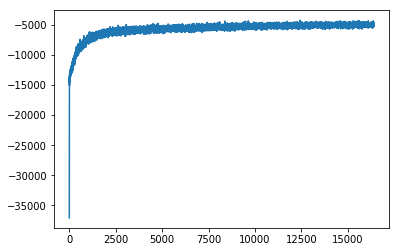

In [472]:
vae.fit(X, 15, 64)

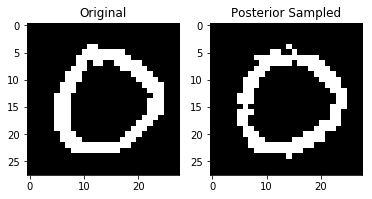

In [478]:
i = np.random.choice(len(X))
x = X[i].reshape(1, 28, 28, 1)
im = vae.posterior_predictive_sample(x).reshape(28, 28)
plt.subplot(1, 2, 1)
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(im, cmap='gray')
plt.title("Posterior Sampled")
plt.show()

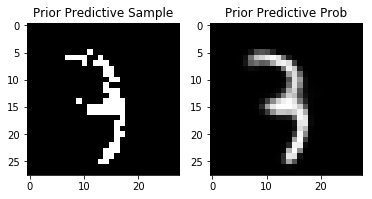

In [479]:
random = np.random.randn(28, 28, 1)
im, prob = vae.prior_predictive_sample_with_prob([random])
plt.subplot(1, 2, 1)
plt.imshow(im.reshape(28, 28), cmap='gray')
plt.title('Prior Predictive Sample')
plt.subplot(1, 2, 2)
plt.imshow(prob.reshape(28, 28), cmap='gray')
plt.title("Prior Predictive Prob")
plt.show()